In [8]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import os
import tensorflow as tf
import keras
from keras import layers
import cv2
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard
import tqdm

In [2]:
# hyper-parameters
ROOT_FOLDER = "..\.."
DATA_FOLDER = os.path.join(ROOT_FOLDER, "data")
TRAIN_FOLDER = os.path.join(DATA_FOLDER, "train_set")
TEST_FOLDER = os.path.join(DATA_FOLDER, "test_set")
PROCESSED_DATA = os.path.join(ROOT_FOLDER, 'processed_data')
TEMPLATE_FOLDER = os.path.join(PROCESSED_DATA, 'templates')

In [3]:
def create_dataset(processed_data=True, train=True, anomaly=False):
    """
    gather all files from all folders in the train or test folder

    :type: str representing which files we want
    :return: list containing
    """

    # define whether to use train or test set
    if train:
        data_set = 'train_set'
    else:
        data_set = 'test_set'

    # define whether to use processed or original data
    if processed_data:
        data_folder = PROCESSED_DATA
        templates = [1,2,3,4,5,6]
    else:
        data_folder = DATA_FOLDER
        template_folder = os.path.join(DATA_FOLDER, data_set)
        templates = os.listdir(template_folder)

    # choose anomalous dice if set as parameter
    if anomaly:
        templates = ["ano"]

    # initialize return types
    data = []
    label = []

    for template in templates:
        # get the folder name, all filenames inside it, and make a list of all the image files inside
        train_folder = os.path.join(data_folder, data_set)
        folder = os.path.join(train_folder, str(template))
        filenames = os.listdir(folder)
        files = [file for file in filenames if ".png" in file]

        for file in files:
            img = Image.open(os.path.join(folder,file))
            data.append(np.array(img))
            label.append(template)
            
    label= np.array(label).reshape(-1,1)

    return data, label


In [4]:
def SSIMLoss(y_true, y_pred):
  y_true = tf.cast(y_true,tf.float32)
  y_pred = tf.cast(y_pred,tf.float32)
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred,1.0))

In [5]:
def split_and_preprocess_dataset(data, split = True):
    data = np.array(data)
    preprocessed_data = data/255
    preprocessed_data = np.expand_dims(preprocessed_data, axis=3)

    if not split:
        return preprocessed_data, _, _, _, _, _, _, _

    # split data in train/val/test set
    train_val_data, test_data, train_val_labels, test_labels = train_test_split(
        preprocessed_data, 
        labels,
        test_size=0.2, 
        random_state=42, 
        shuffle=True
    )

    train_data, val_data, train_labels, val_labels = train_test_split(
        train_val_data, 
        train_val_labels,
        test_size=0.3, 
        random_state=42, 
        shuffle=True
    )

    return train_val_data, test_data, train_val_labels, test_labels, train_data, val_data, train_labels, val_labels

In [6]:
# gather, process and preprocess all training data.

data, labels = create_dataset(processed_data=True, train=True)
train_val_data, test_data, train_val_labels, test_labels, train_data, val_data, train_labels, val_labels = split_and_preprocess_dataset(data)

In [7]:
# gather, process and preprocess all training data.

anomalies, _ = create_dataset(processed_data=True, train=True, anomaly=True)
anomalies, _, _, _, _, _, _, _ = split_and_preprocess_dataset(anomalies, split = False)
#anomalies = [x.reshape(128, 128, 1) for x in anomalies]

In [8]:
# build model

# input size is (128, 128). That means the input is 16.384 floats. In the input below they have an input of 784.
input_shape = (128, 128, 1)

"""
# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
"""

# like the example above we takle encoding dimension as a factor 24
encoding_dim = 668

# This is our input image
input_img = keras.Input(shape=input_shape)
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(1, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

history = autoencoder.fit(train_data, train_data,
                epochs=2,
                batch_size=10,
                shuffle=True,
                validation_data=(val_data, val_data),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/2
368/368 [==============================] - 281s 760ms/step - loss: 0.3779 - val_loss: 0.3406
Epoch 2/2
368/368 [==============================] - 258s 701ms/step - loss: 0.3286 - val_loss: 0.3183


In [11]:
autoencoder.save('../../models/v0-1.h5')

In [9]:
autoencoder = tf.keras.models.load_model('../../models/v0-1.h5')

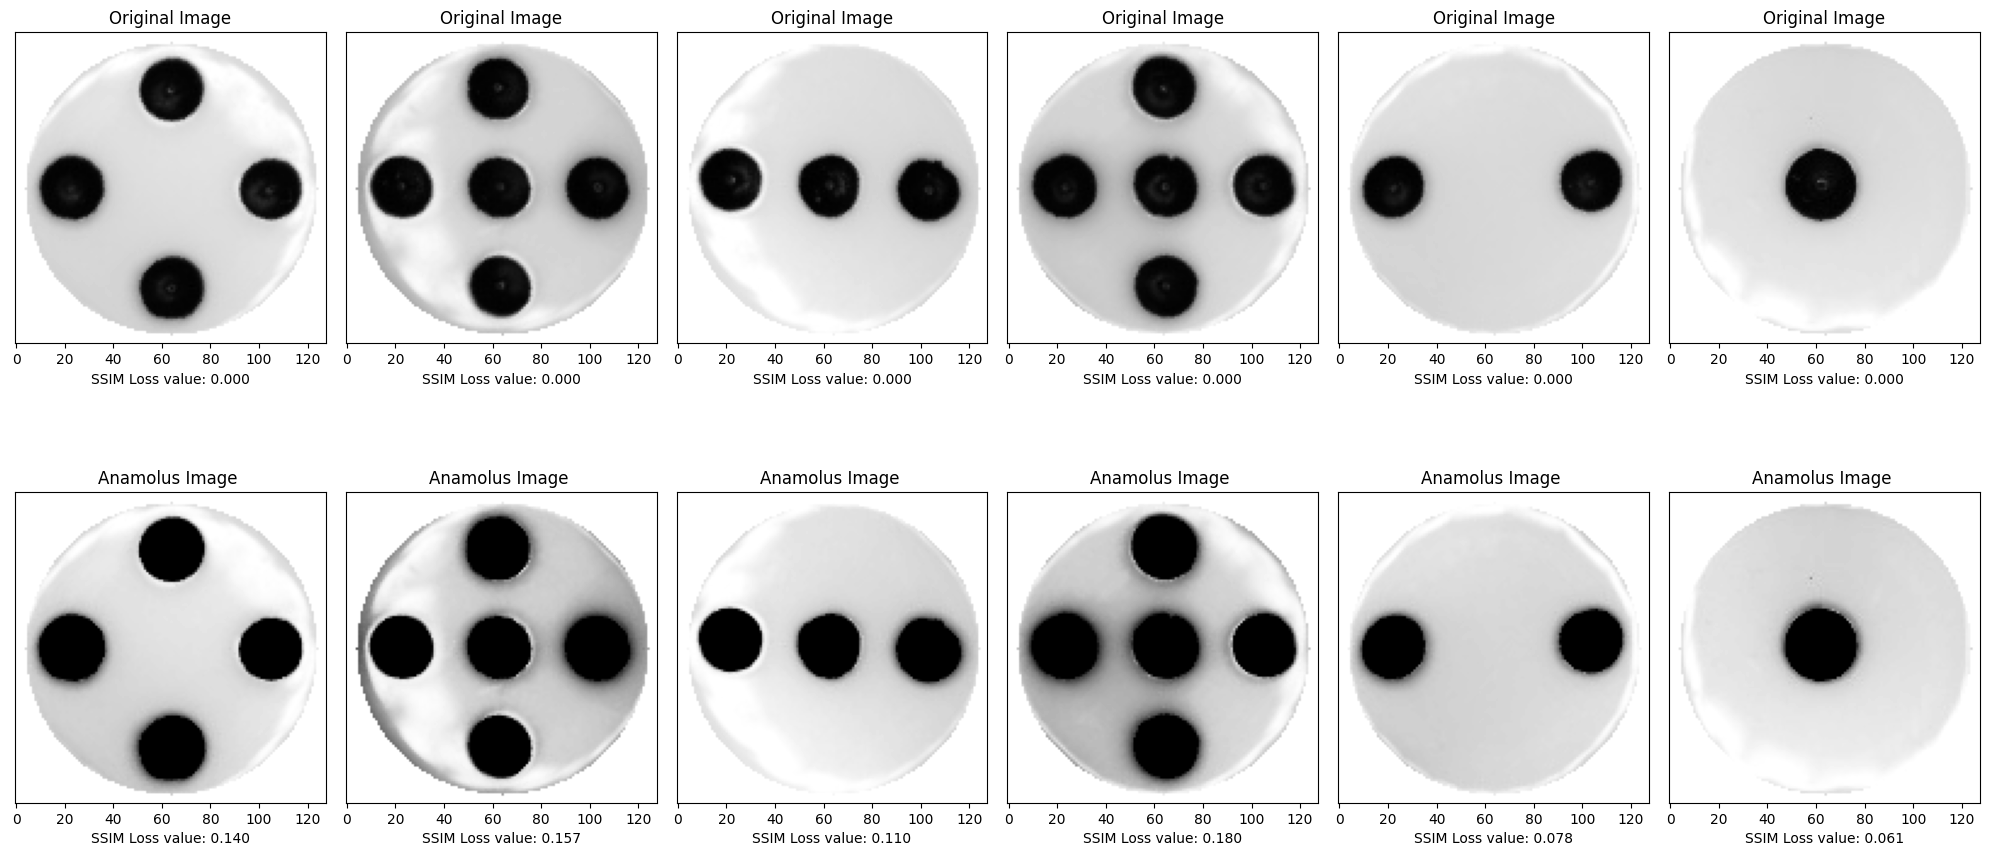

In [10]:
%matplotlib inline
n = 6  # how many encoded and decoded images we will display

plt.figure(figsize=(20, 14), dpi=100)
plt.subplots_adjust( wspace=0.1, hspace=0.07)
plt_a=1

decoded_imgs = []
decoded_mnistimgs = []

for i in range(n):

    decoded_imgs.append(autoencoder.predict(test_data[i]))

for i in range(n):

    # Original training dataset vs Original training
    ax = plt.subplot(3, n, plt_a   )
    plt.imshow(test_data[i].reshape(128,128), cmap="gray")
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(test_data[i], test_data[i])
    ax.set_title("Original Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )

    # Reconstructed anomalous data  vs Original training data
    ax = plt.subplot(3, n, plt_a + n)
    img_2 = decoded_imgs[i].reshape(128,128,1)
    plt.imshow(img_2.reshape(128,128), cmap="gray")
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value = SSIMLoss(img_2, test_data[i])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_title("Anamolus Image " )
    ax.set_xlabel(label.format(value) )
    plt_a+=1
    
plt.tight_layout()
plt.show()

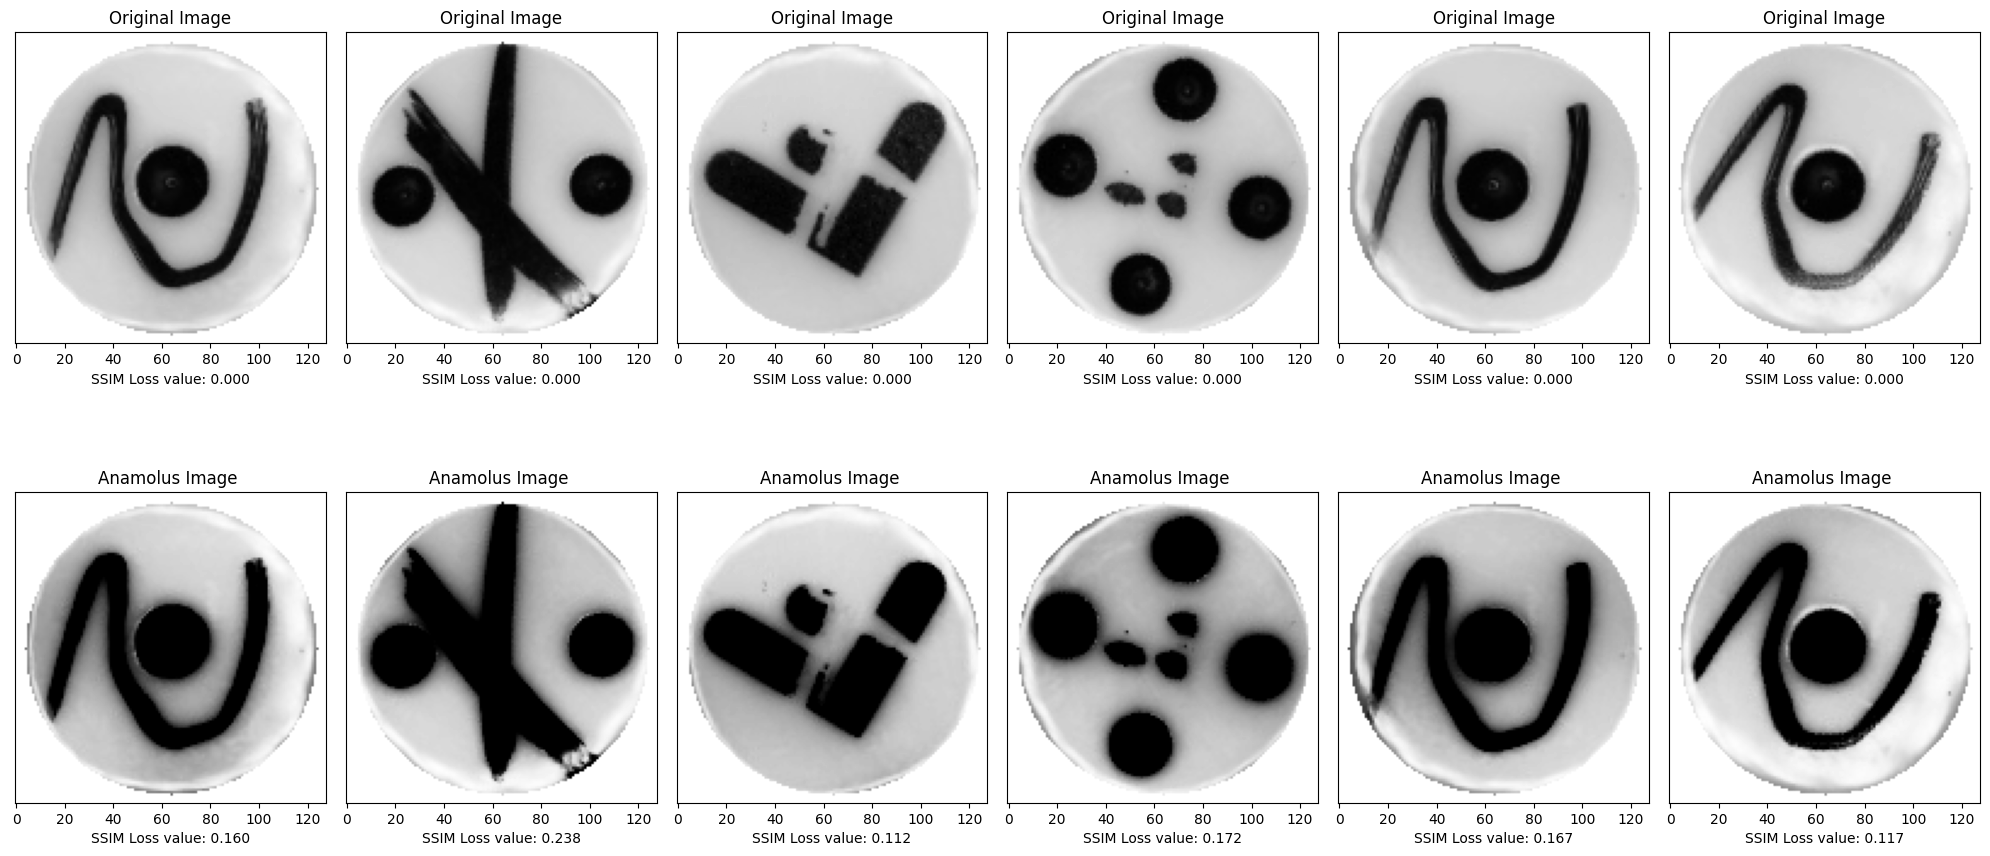

In [11]:
%matplotlib inline
n = 6  # how many encoded and decoded images we will display

plt.figure(figsize=(20, 14), dpi=100)
plt.subplots_adjust( wspace=0.1, hspace=0.07)
plt_a=1

decoded_imgs = []
decoded_mnistimgs = []

for i in range(n):

    decoded_mnistimgs.append(autoencoder.predict(anomalies[i]))

for i in range(n):

    # Original training dataset vs Original training
    ax = plt.subplot(3, n, plt_a   )
    plt.imshow(anomalies[i].reshape(128,128), cmap="gray")
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(anomalies[i], anomalies[i])
    ax.set_title("Original Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )

    # Reconstructed anomalous data  vs Original training data
    ax = plt.subplot(3, n, plt_a + n)
    img_2 = decoded_mnistimgs[i].reshape(128,128,1)
    plt.imshow(img_2.reshape(128,128), cmap="gray")
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value = SSIMLoss(img_2, anomalies[i])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_title("Anamolus Image " )
    ax.set_xlabel(label.format(value) )
    plt_a+=1
    
plt.tight_layout()
plt.show()

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_stats(predictions, labels):
  print("f1 = {}".format(f1_score(labels, predictions)))
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [13]:
ano_predictions = []

for ano in anomalies:

    result = autoencoder.predict(ano).reshape(128,128,1)

    ano_predictions.append(SSIMLoss(ano, result).numpy())

In [14]:
norm_predictions = []

for sample in tqdm.tqdm(test_data):

    result = autoencoder.predict(sample).reshape(128,128,1)

    norm_predictions.append(SSIMLoss(sample, result).numpy())

100%|██████████| 1315/1315 [03:11<00:00,  6.87it/s]


In [15]:
threshold = np.mean(norm_predictions) + (np.mean(norm_predictions) + np.mean(ano_predictions))/12

In [16]:
np.max(norm_predictions), threshold

(0.19302875, 0.14187879612048468)

In [17]:
def predictor(ano_pred, norm_pred, threshold):
    threshold = np.float32(threshold)
    predictions = []
    labels = []

    for pred in ano_pred:
        labels.append(1)
        if pred > threshold:
            predictions.append(1)
        else:
            predictions.append(0)

    for pred in norm_pred:
        labels.append(0)
        if pred > threshold:
            predictions.append(1)

        else:
            predictions.append(0)


    return predictions, labels


In [18]:
predictions, labels = predictor(ano_predictions, norm_predictions, threshold)

In [19]:
print_stats(predictions, labels)

f1 = 0.12605042016806722
Accuracy = 0.6965718453683443
Precision = 0.07142857142857142
Recall = 0.5357142857142857


In [59]:
predictions, labels

([0,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,


In [26]:
ano_predictions

[0.1604138,
 0.23800802,
 0.11201054,
 0.17246121,
 0.16681588,
 0.116913855,
 0.12923741,
 0.118526995,
 0.04732865,
 0.2549249,
 0.24154001,
 0.2079733,
 0.11010903,
 0.17022711,
 0.16425699,
 0.16146839,
 0.118778884,
 0.117996514,
 0.051152945,
 0.22450644,
 0.11269683,
 0.10532439,
 0.17295605,
 0.15556246,
 0.15566677,
 0.13362145,
 0.112473726,
 0.05101061,
 0.16003984,
 0.25909847,
 0.24524528,
 0.11198628,
 0.0901919,
 0.1696083,
 0.15294331,
 0.18220514,
 0.15159094,
 0.13412714,
 0.123159945,
 0.14599341,
 0.24748307,
 0.12540609,
 0.115042865,
 0.11107057,
 0.13316476,
 0.14022303,
 0.11905396,
 0.17069983,
 0.14767563,
 0.10683805,
 0.23017168,
 0.14071774,
 0.17132163,
 0.16881764,
 0.16242182,
 0.14838314]

In [52]:
np.mean(result)

0.8723926544189453

In [53]:
result = predict(autoencoder, test_data[0],0.5)

In [54]:
np.mean(result)

0.8629279136657715

In [32]:
inputs = tf.keras.Input(shape=(128, 128, 1), name='input_layer')


In [33]:
# Conv Block 1 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_1')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_1')(encoded)
# Conv Block 2 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_2')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_2')(encoded)
# Conv Block 3 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_3')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_3')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_3')(encoded)

In [34]:
# DeConv Block 1-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(encoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_4')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_4')(decoded)
# DeConv Block 2-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_5')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_5')(decoded)
# DeConv Block 3-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_6')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_6')(decoded)

In [35]:
outputs = tf.keras.layers.Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(decoded)


In [61]:
def SSIMLoss(y_true, y_pred):
  y_true = tf.cast(y_true,tf.float32)
  y_pred = tf.cast(y_pred,tf.float32)
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred,1.0))

In [37]:
autoencoder = tf.keras.Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(lr = 0.0005)
autoencoder.compile(optimizer=optimizer, loss=SSIMLoss)

C:\Users\User\anaconda3\envs\computer_vision\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [38]:
autoencoder.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128, 128, 1)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 128, 128, 32)     128       
 tion)                                                           
                                                                 
 leaky_relu_1 (LeakyReLU)    (None, 128, 128, 32)      0         
                                                                 
 conv_2 (Conv2D)             (None, 64, 64, 64)        18496     
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 64, 64, 64)       256       
 tion)                                                     

In [39]:
dot_img_file = '../assets/autoencoder.png'
tf.keras.utils.plot_model(autoencoder, to_file=dot_img_file, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [40]:
!rm -rf ./logs/


'rm' is not recognized as an internal or external command,
operable program or batch file.


In [41]:
from keras.callbacks import TensorBoard


In [43]:
hist=autoencoder.fit(train_val_data, train_val_data,
                epochs=2,
                batch_size=128,
                shuffle=True,
                validation_data=(test_data, test_data), callbacks=[TensorBoard(log_dir='../assets/')])

Epoch 1/2
39/39 [==============================] - 710s 18s/step - loss: 0.1171 - val_loss: 0.4449
Epoch 2/2
39/39 [==============================] - 764s 19s/step - loss: 0.0701 - val_loss: 0.4239


In [ ]:
%load_ext tensorboard
%tensorboard --logdir='../assets/' #Specify the path in fit

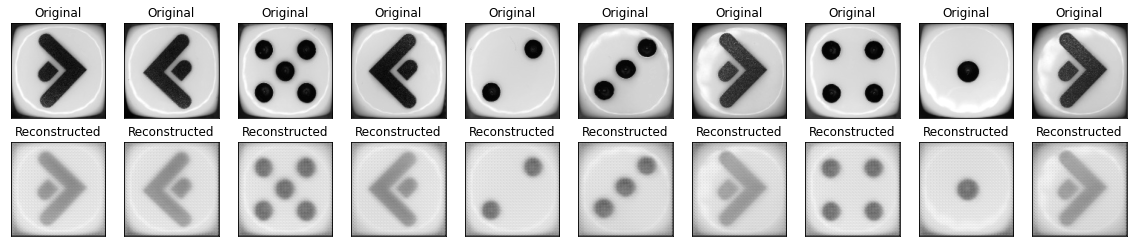

In [47]:
decoded_imgs = autoencoder.predict(test_data)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(test_data[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    plt.title("Original")
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.title("Reconstructed")
    plt.imshow(decoded_imgs[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [50]:
def create_dataset_ano():
    directory = "../assets/train_set/ano"
    data= []
    label= []
    for filename in os.listdir(directory):
        if filename.endswith(".png"):
            img = Image.open(directory+"/"+filename)
            data.append(np.array(img))
                
    print(len(data))
    return data

In [51]:
anomalies = create_dataset_ano()


56


In [53]:
anomalies = np.array(anomalies)

In [54]:
anomalies.shape


(56, 128, 128)

In [67]:
anomalies = np.expand_dims(anomalies,axis=3)

In [68]:
anomalies.shape

(56, 128, 128, 1)

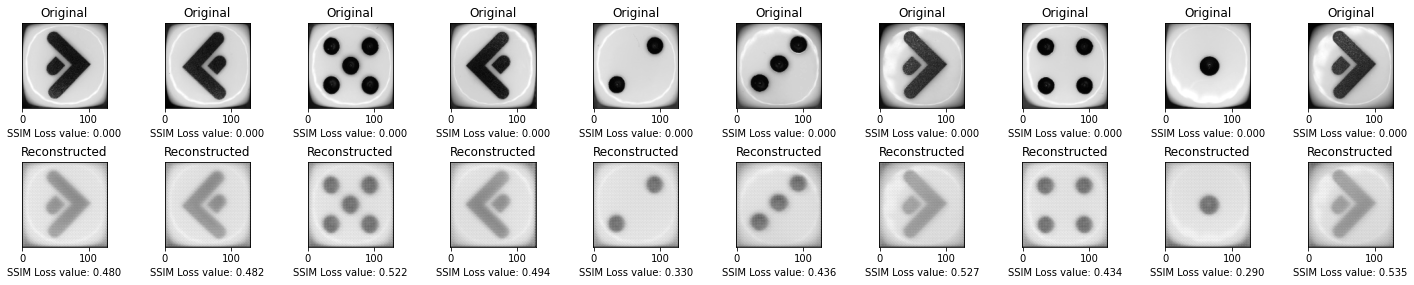

In [64]:
decoded_imgs = autoencoder.predict(test_data)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(test_data[i].reshape(128, 128))
    plt.gray()
    plt.title("Original")
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(test_data[i], test_data[i])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.title("Reconstructed")
    plt.imshow(decoded_imgs[i].reshape(128, 128))
    plt.gray()
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(decoded_imgs[i], test_data[i])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a))
plt.tight_layout()
plt.show()

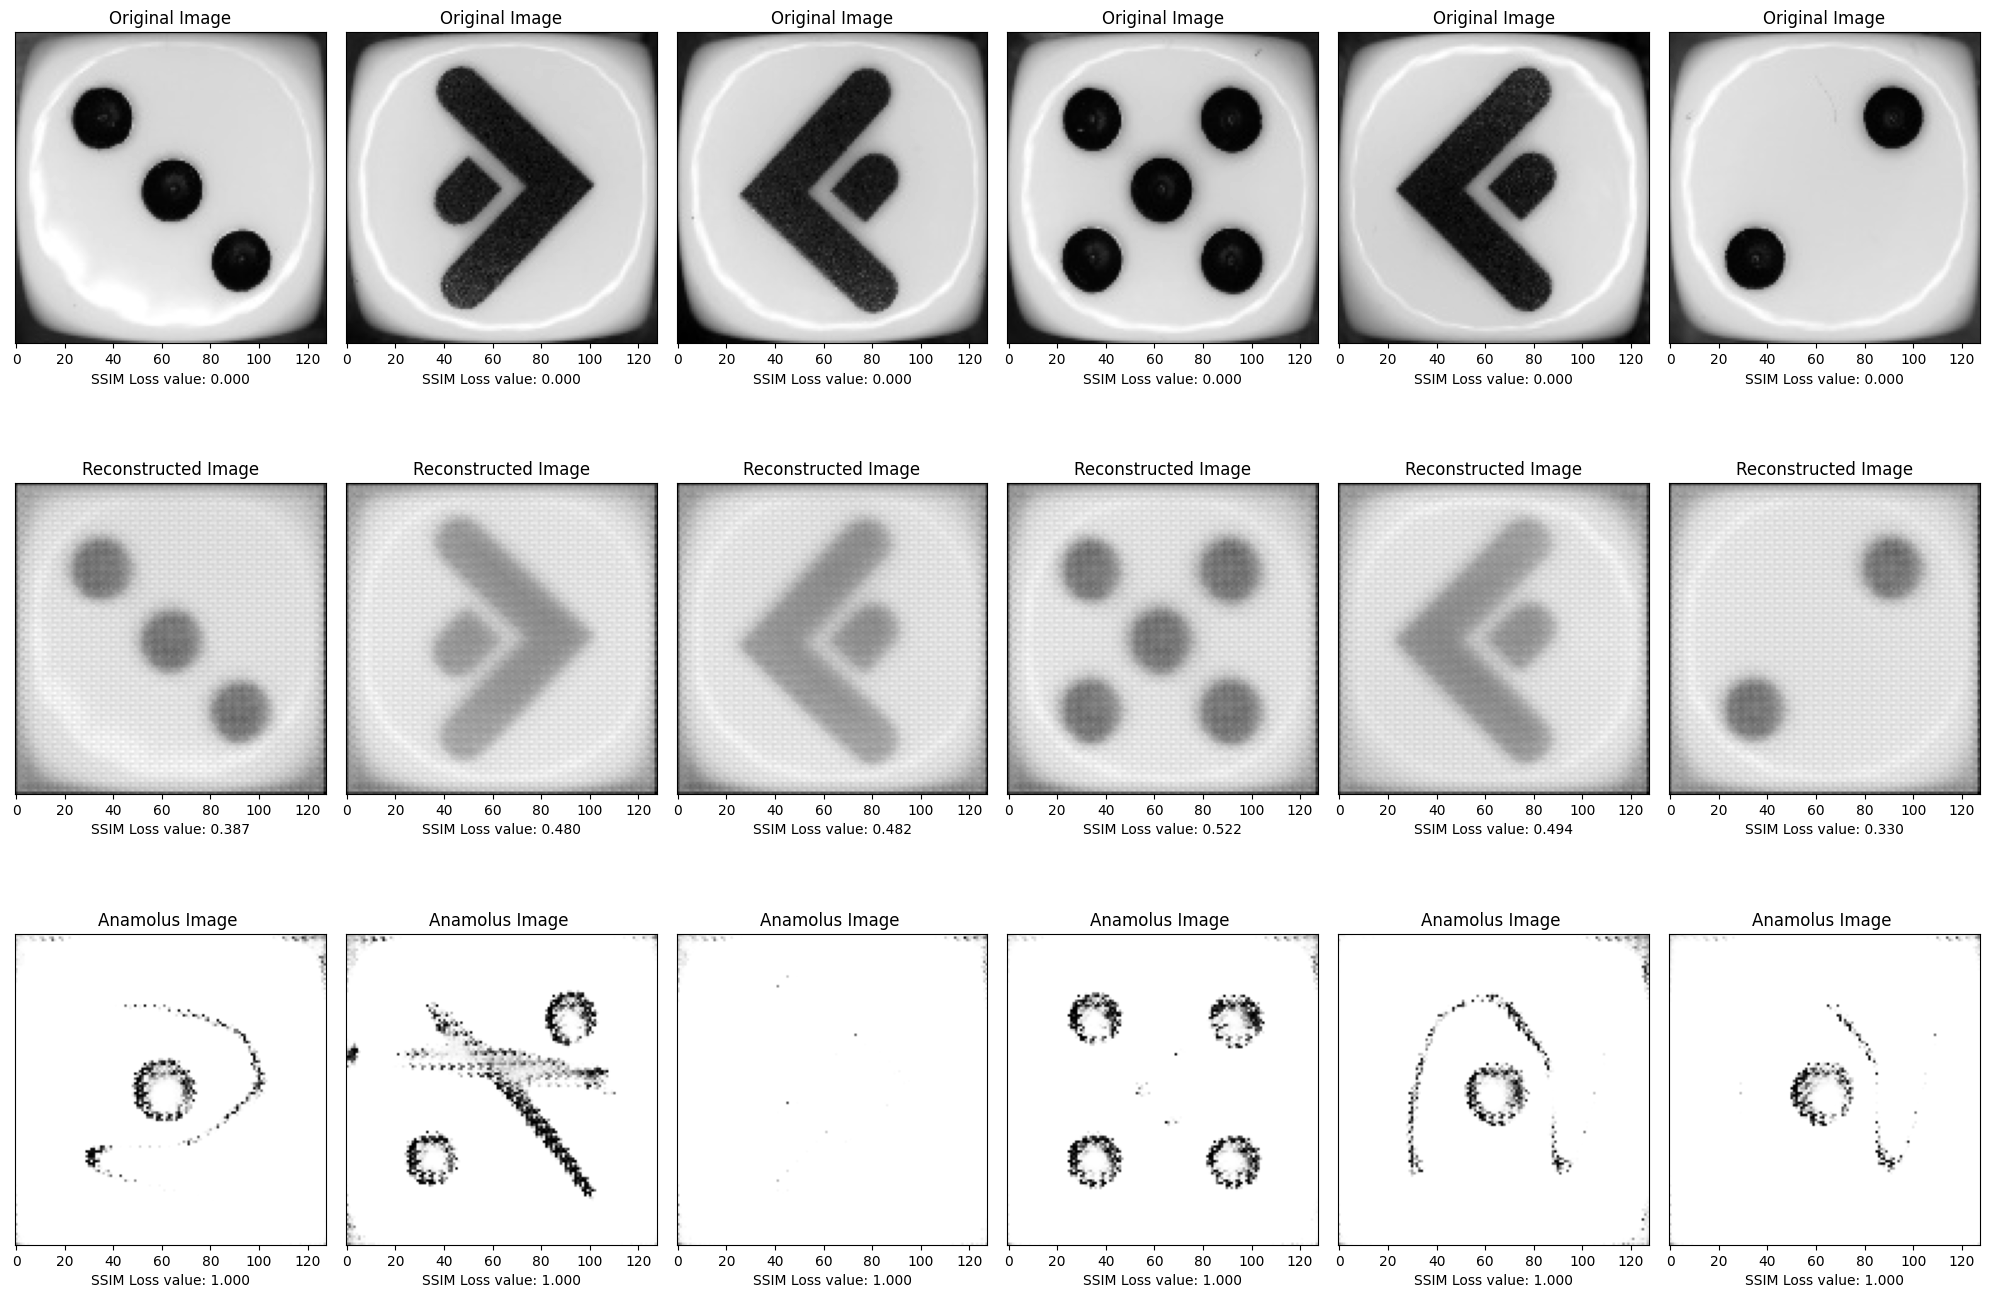

In [69]:
%matplotlib inline
n = 6  # how many encoded and decoded images we will display
decoded_imgs= autoencoder.predict(test_data)
decoded_mnistimgs= autoencoder.predict(anomalies)
plt.figure(figsize=(20, 14), dpi=100)
plt.subplots_adjust( wspace=0.1, hspace=0.07)
plt_a=1
for i in range(n):
    # Original training dataset vs Original training
    ax = plt.subplot(3, n, plt_a   )
    plt.imshow(test_data[i].reshape(128,128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(test_data[i], test_data[i])
    ax.set_title("Original Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )
    
    # Reconstructed good data  vs Original training data
    ax = plt.subplot(3, n, plt_a + n )
    plt.imshow(decoded_imgs[i].reshape(128,128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)    
    value_a = SSIMLoss(decoded_imgs[i], test_data[i])
    ax.set_title("Reconstructed Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )
    
    # Reconstructed anomalous data  vs Original training data
    ax = plt.subplot(3, n, plt_a + 2*n)
    plt.imshow(decoded_mnistimgs[i].reshape(128,128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value = SSIMLoss(decoded_mnistimgs[i], anomalies[i])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_title("Anamolus Image " )
    ax.set_xlabel(label.format(value) )
    plt_a+=1
plt.tight_layout()
plt.show()